In [1]:
""" Script for analysing all VR trials in one experiment folder (assumes use of FlyOver version 9.2 or higher) """

__author__ = 'Hannah Haberkern, hjmhaberkern@gmail.com'

import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk
from os.path import isfile, sep
from sys import path, exit
from glob import glob

from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

path.insert(1, '/Users/hannah/Dropbox/code/flyVR/flyVRAnalysis/')
from flyVR_oneTrialBasicAnalysis import singleVRTrialAnalysis

path.insert(1, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import makeNestedPlotDirectory, myAxisTheme
from objectInteractionPlots import residencyWithHistograms_splitOnWalking, curvatureVsHeading_DistanceBoxplot, plotResidencyInMiniarena

path.insert(1, '/Users/hannah/Dropbox/code/trajectoryAnalysis/')
from trajectoryDerivedParams import relationToObject

%matplotlib inline 

# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['WTBm01', 'WTBm02', 'WTBm03', 'WTBm04', 'WTBm05', 'WTBm06', 'WTBm07', 'WTBm08', 'WTBm09', 'WTBm10', 'WTBm11', 'WTBm12', 'WTBm13', 'WTBm14', 'WTBm15', 'WTBm16', 'WTBm17', 'WTBm18', 'WTBm19', 'WTBm20']
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


In [289]:
from operator import itemgetter
my_indices = [1,3,4,9,14,18] #[1,2,3,4,5,9,10,14,15,17,18]
expDirs = itemgetter(*my_indices)(expDirs)
expDirs

('WTBm02', 'WTBm04', 'WTBm05', 'WTBm10', 'WTBm15', 'WTBm19')

### Compose mutli-fly data into dataframe

In [290]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

In [291]:
expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [292]:
keylist = ['curvature','gamma','gammaFull','headingAngle','objectDistance','rotVelo','time',
           'transVelo','xPos','xPosInMiniarena','yPos','yPosInMiniarena']

keylistLong = ['flyID','trial','trialtype','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

In [293]:
nTrialsVI = 0
nTrialsIN = 0
 
vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:

        flyID = fileToAnalyse.split('_')[0]
        trial = FODataFiles.index(fileToAnalyse) + 1
        
        if rerunbasicanalysis == 'y':
            returnVal = singleVRTrialAnalysis(expDir + fileToAnalyse)
            print('Ran analysis, now loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        else:
            print('Loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

        # Split into visible object trials and invisible object trials
        if 'Invisible' in fileToAnalyse or 'invisible' in fileToAnalyse:
            trialtype = 'invisible'
            nTrialsIN += 1
        else:
            trialtype = 'visible'
            nTrialsVI += 1
        
        vTrans = np.copy(FODatLoad['transVelo'])
        moving = vTrans >= vTransTH

        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'moving', moving)
        
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)
        
        # TODO: Add selection criteria, e.g. to only include trials from flies that were 
        # walking >40% of time and did not have a strong turn bias.
        


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTB/males/rawData/WTBm02/

 Analysing the following log files:

['WTBm02_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5d_out_151121162549.txt', 'WTBm02_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5d_out_151121163554.txt', 'WTBm02_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5d_out_151121164557.txt', 'WTBm02_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_5d_out_151121161429.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTB/males/rawData/WTBm04/

 Analysing the following log files:

['WTBm04_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5d_out_151123202627.txt', 'WTBm04_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5d_out_151123204202.txt', 'WTBm04_FlyOver

In [294]:
FOAllFlies_df =FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')

FOAllFlies_df 

flyID trial  trialtype  moving  curvature     gamma  gammaFull  \
0      WTBm02     1    visible       1        NaN       NaN        NaN   
1      WTBm02     1    visible       1        NaN       NaN        NaN   
2      WTBm02     1    visible       1        NaN       NaN        NaN   
3      WTBm02     1    visible       0        NaN       NaN        NaN   
4      WTBm02     1    visible       0        NaN       NaN        NaN   
5      WTBm02     1    visible       0        NaN       NaN        NaN   
6      WTBm02     1    visible       0        NaN       NaN        NaN   
7      WTBm02     1    visible       0        NaN       NaN        NaN   
8      WTBm02     1    visible       0        NaN       NaN        NaN   
9      WTBm02     1    visible       1        NaN       NaN        NaN   
10     WTBm02     1    visible       1        NaN       NaN        NaN   
11     WTBm02     1    visible       1        NaN       NaN        NaN   
12     WTBm02     1    visible       1        NaN       NaN        NaN   
13     WTBm02     1    visible       1        NaN       NaN        NaN   
14     WTBm02     1    visible       1        NaN       NaN        NaN   
15     WTBm02     1    visible       0        NaN       NaN        NaN   
16     WTBm02     1    visible       1        NaN       NaN        NaN   
17     WTBm02     1    visible       1        NaN       NaN        NaN   
18     WTBm02     1    visible       1        NaN       NaN        NaN   
19     WTBm02     1    visible       1        NaN       NaN        NaN   
20     WTBm02     1    visible       1        NaN       NaN        NaN   
21     WTBm02     1    visible       1        NaN       NaN        NaN   
22     WTBm02     1    visible       1        NaN       NaN        NaN   
23     WTBm02     1    visible       1        NaN       NaN        NaN   
24     WTBm02     1    visible       1        NaN       NaN        NaN   
25     WTBm02     1    visible       1        NaN       NaN        NaN   
26     WTBm02     1    visible       1        NaN       NaN        NaN   
27     WTBm02     1    visible       1        NaN       NaN        NaN   
28     WTBm02     1    visible       1        NaN       NaN        NaN   
29     WTBm02     1    visible       1        NaN       NaN        NaN   
...       ...   ...        ...     ...        ...       ...        ...   
11970  WTBm19     4  invisible       0        NaN  2.846615   2.846615   
11971  WTBm19     4  invisible       1        NaN  2.842959   2.842959   
11972  WTBm19     4  invisible       1        NaN  2.841188   2.841188   
11973  WTBm19     4  invisible       0        NaN  2.830883   2.830883   
11974  WTBm19     4  invisible       0        NaN  2.803862   2.803862   
11975  WTBm19     4  invisible       0        NaN  2.774556   2.774556   
11976  WTBm19     4  invisible       0        NaN  2.751864   2.751864   
11977  WTBm19     4  invisible       0        NaN  2.745947   2.745947   
11978  WTBm19     4  invisible       0        NaN  2.740031   2.740031   
11979  WTBm19     4  invisible       0        NaN  2.742980   2.742980   
11980  WTBm19     4  invisible       0        NaN  2.748897   2.748897   
11981  WTBm19     4  invisible       0        NaN  2.751864   2.751864   
11982  WTBm19     4  invisible       0        NaN  2.751864   2.751864   
11983  WTBm19     4  invisible       0        NaN  2.751869   2.751869   
11984  WTBm19     4  invisible       0        NaN  2.746185   2.746185   
11985  WTBm19     4  invisible       0        NaN  2.746185   2.746185   
11986  WTBm19     4  invisible       0        NaN  2.746185   2.746185   
11987  WTBm19     4  invisible       0        NaN  2.746185   2.746185   
11988  WTBm19     4  invisible       0        NaN  2.746185   2.746185   
11989  WTBm19     4  invisible       0        NaN  2.749134   2.749134   
11990  WTBm19     4  invisible       0        NaN  2.749134   2.749134   
11991  WTBm19     4  invisible       0        NaN  2.749134   2.749134   
11992  WTBm1

In [295]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_gam = keylistLong.index('gamma')
keyind_gamful = keylistLong.index('gammaFull')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')

In [296]:
genotypeSex = fileToAnalyse.split('_')[0][:-2]

flyIDallarray = np.asarray(FOAllFlies_df.iloc[:,keyind_fly:keyind_fly+1]).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

arenaRad = 60

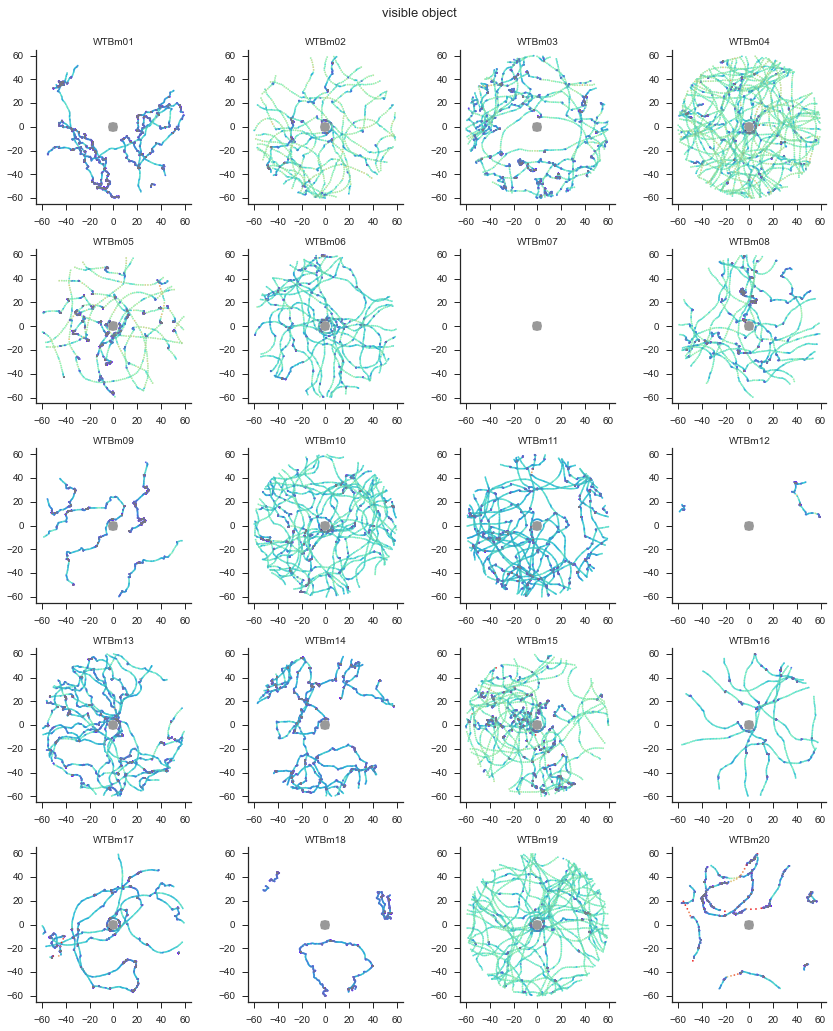

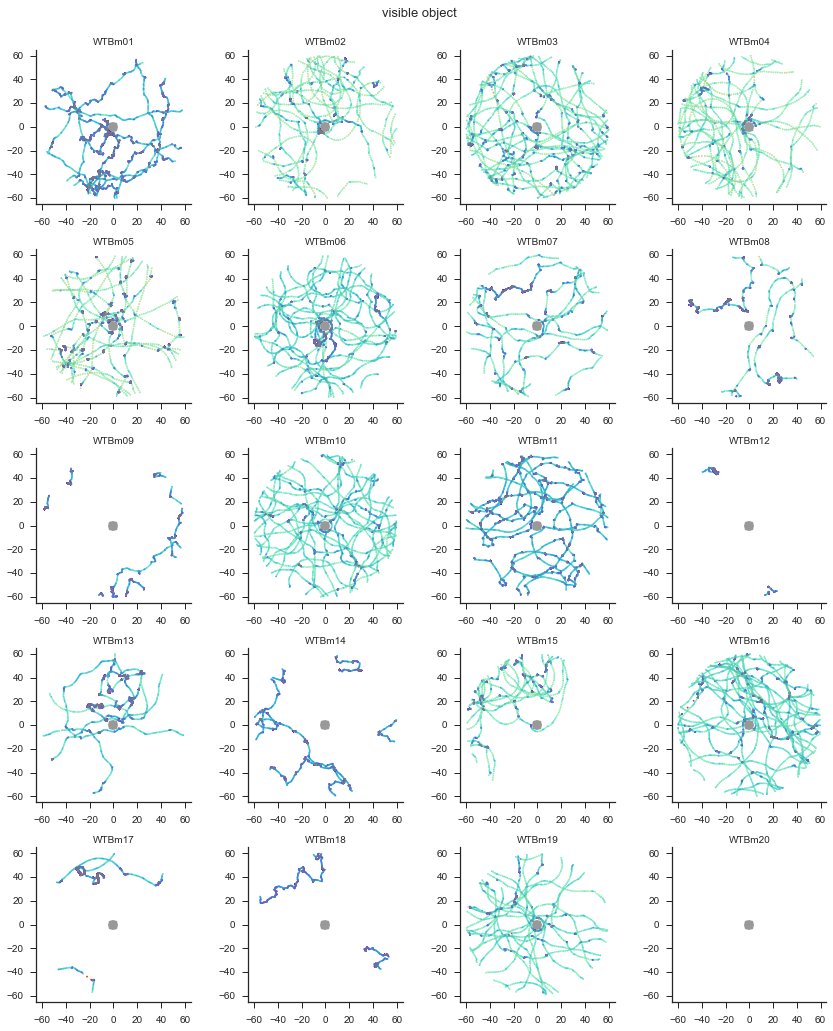

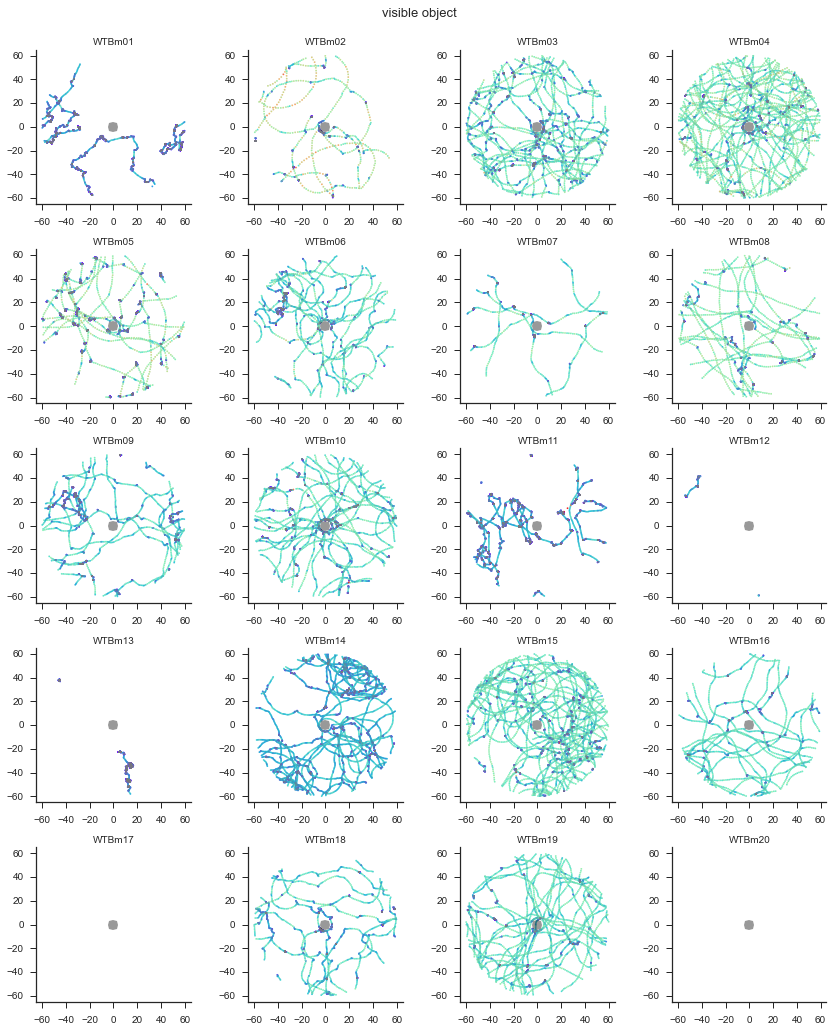

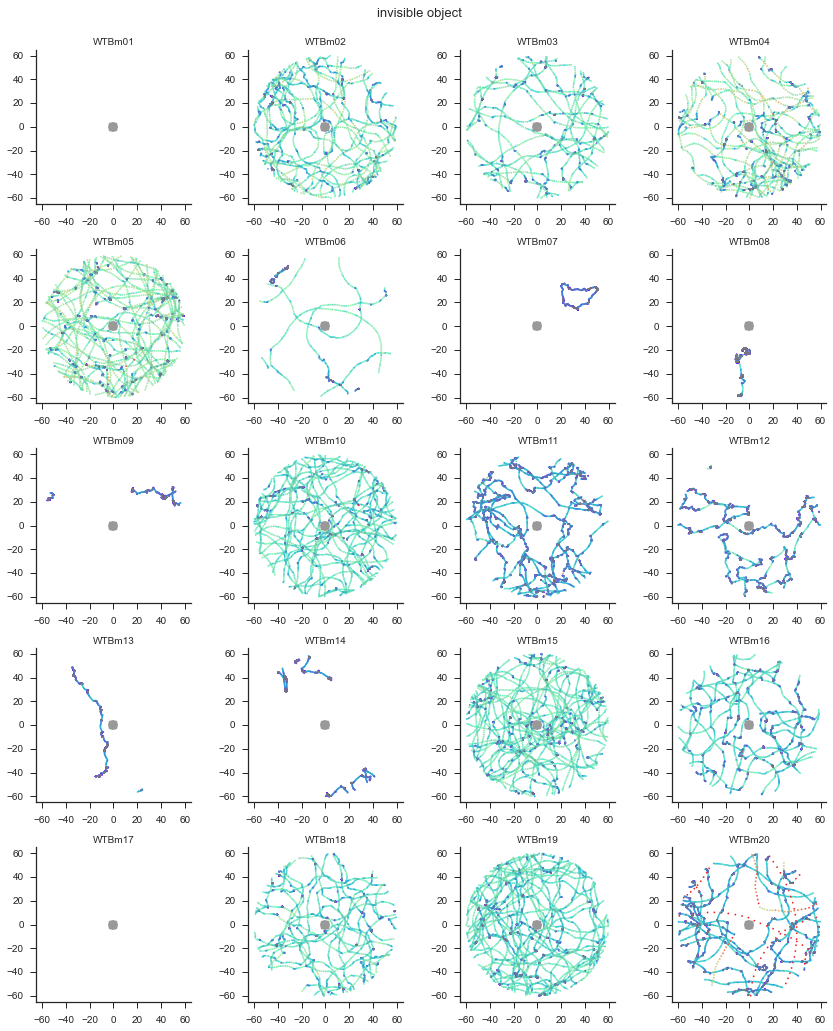

In [32]:
for ttind,trialtype in enumerate(['visible','visible','visible','invisible']):
    multiflyTracePlot = plt.figure(figsize=(12,14))
    figtitle = multiflyTracePlot.suptitle(trialtype + ' object',fontsize=13,y=1.02)
    for fly in range(numFlies):
        multiflyTracePlot_sbplt = multiflyTracePlot.add_subplot(5,4,fly+1)
       
        querystring = '(trialtype=="' + trialtype + '") & (trial==' + str(ttind+1) + ') & (flyID =="' + flyIDs[fly] +  '")'

        perFlyX = FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1].squeeze()
        perFlyY = FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1].squeeze()
        perFlyvT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].squeeze()
        
        selectPts = range(0,len(perFlyX),2)
        #color = scalarMap.to_rgba(timecolor), alpha = 0.1)
        multiflyTracePlot_sbplt.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
        multiflyTracePlot_sbplt.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                        vmin=-1, vmax=35, edgecolor='none',alpha=0.9)
        multiflyTracePlot_sbplt.plot(0,0,'o',markersize=10, color='black', alpha=0.4)
        
        myAxisTheme(multiflyTracePlot_sbplt)
        multiflyTracePlot_sbplt.set_title(flyIDs[fly],fontsize=10)
        multiflyTracePlot_sbplt.set_aspect('equal')
        multiflyTracePlot_sbplt.set_xlim(-arenaRad-5, arenaRad + 5)
        multiflyTracePlot_sbplt.set_ylim(-arenaRad-5, arenaRad + 5)
        
    multiflyTracePlot.tight_layout()
    
    # analysisDir + 'tracePlotMA/' should already exist from single trial analysis
    # makeNestedPlotDirectory(analysisDir, 'tracePlotMA/', objecttype + sep)
    multiflyTracePlot.savefig(analysisDir + 'tracePlotMA/'  + genotypeSex + '_' + trialtype
                              + '_traceVeloColored_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf', 
                              bbox_extra_artists=(figtitle,), bbox_inches='tight')

In [26]:
def plotVeloDistribution_flyVR_df(mydataframe, trialtype, trial, flyIDs):
    from matplotlib import gridspec
    
    veloDistFig = plt.figure(figsize=(10,3))
    #fig.set_canvas(plt.gcf().canvas)
    #sns.set_palette('husl', n_colors = len(flyIDs)+1)
    gs = gridspec.GridSpec(1,3,width_ratios=(3,3,1))

    vTsubplt = veloDistFig.add_subplot(gs[0])
    vTsubplt.set_xlabel('translational velocity [mm/s]')
    vTsubplt.set_ylabel('count')
    sns.despine(right=True, offset=5,trim=False)
    sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})

    vRsubplt = veloDistFig.add_subplot(gs[1])
    vRsubplt.set_xlabel('rotational velocity [rad/s]')
    sns.despine(right=True, offset=5,trim=False)
    sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})

    for flyInd, flyID in enumerate(flyIDs):
        querystring = '(moving==1) & (trialtype == "'+ trialtype +'") & (trial=='+trial+') & (flyID == "' + flyID +  '")'
        tV = mydataframe.query(querystring).iloc[:,keyind_vT:keyind_vT+1].squeeze()
        rV = mydataframe.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze()

        ntV,binEdges=np.histogram(tV,bins=50,range = (vTransTH, 30))
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])

        vTsubplt.plot(bincenters,ntV,alpha=0.8,color=flyCMap.to_rgba(flyInd))

        nrV,binEdges=np.histogram(rV,bins=50,range = (-5, 5))
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])

        vRsubplt.plot(bincenters,nrV,alpha=0.8,color=flyCMap.to_rgba(flyInd))

    vTsubplt.set_xlim((vTransTH, 30))
    
    vRsubplt.set_xlim((-5, 5))
    
    veloDistFig.suptitle(trialtype+' object, trial ' +trial+ ' (moving > '+str(vTransTH)+' mm/s)',fontsize=12)
    vRsubplt.legend(flyIDs, ncol=2,loc=1,bbox_to_anchor=(1,0.9),bbox_transform=plt.gcf().transFigure)

    return veloDistFig

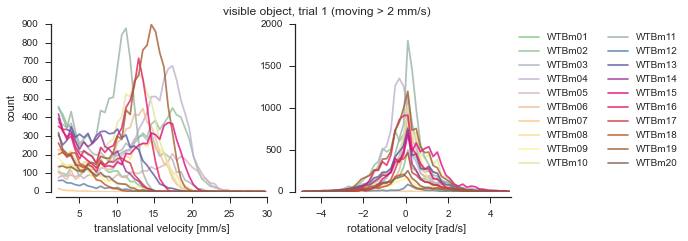

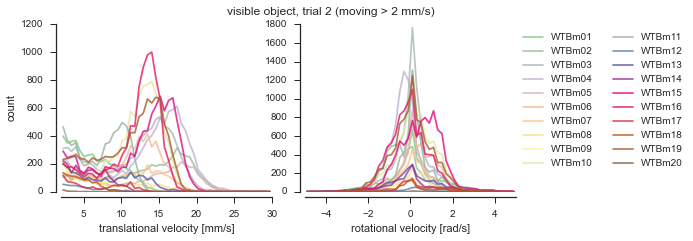

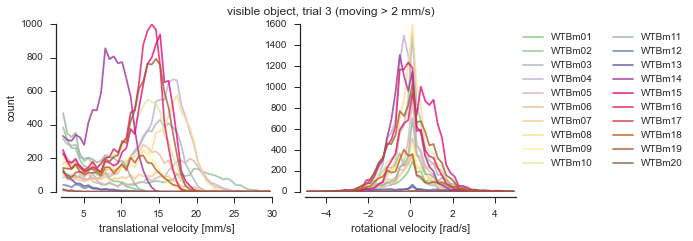

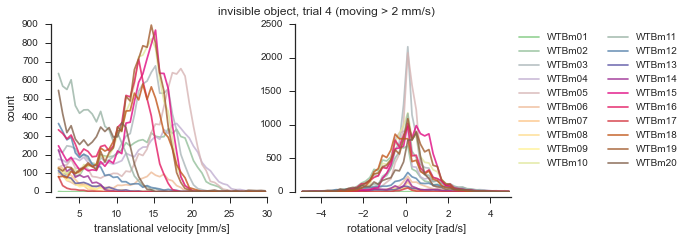

In [33]:
for ttind,trialtype in enumerate(['visible','visible','visible','invisible']):
    veloDistFig = plotVeloDistribution_flyVR_df(FOAllFlies_df, trialtype, str(ttind+1), flyIDs)

    #makeNestedPlotDirectory(analysisDir, 'velocityTraces/', objecttype + sep)
    # analysisDir + 'velocityTraces/' should already exist from single trial analysis
    veloDistFig.savefig(analysisDir + 'velocityTraces/'  + genotypeSex + '_' + trialtype
                        + '_veloDistributions_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

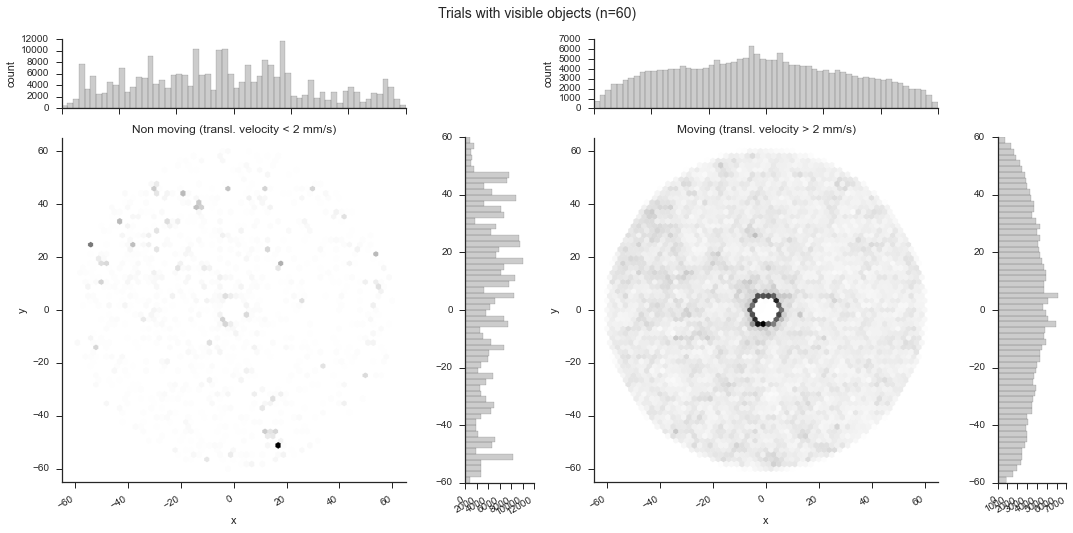

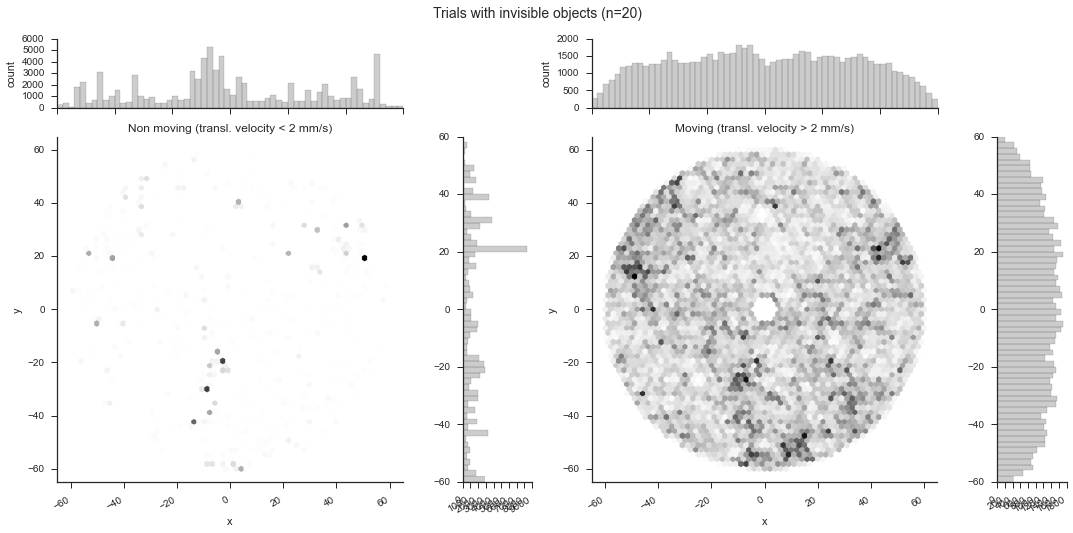

In [127]:
# make fly summary plot of residency:
arenaRad = 60
numBins = 60

keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_vT = keylistLong.index('transVelo')

nTrials = (nTrialsVI,nTrialsIN)

for indcond, condition in enumerate(['visible', 'invisible']):
    querystring = '(trialtype == "' + condition + '")'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    movingall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1]).squeeze().astype('bool')
    vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()

    movingall = vT>vTransTH

    # make plot
    noNans = ~np.isnan(xPosMAall)
    hexplotfig = residencyWithHistograms_splitOnWalking(
        xPosMAall[noNans], yPosMAall[noNans], movingall[noNans], arenaRad, numBins, vTransTH,
        'Trials with ' + condition + ' objects (n=' + str(nTrials[indcond]) + ')')
    
    #makeNestedPlotDirectory(analysisDir, 'velocityTraces/', objecttype + sep)
    # analysisDir + 'residencyPlots/' should already exist from single trial analysis
    hexplotfig.savefig(analysisDir + 'residencyPlots/'  + genotypeSex + '_' + condition
                        + '_residencyMA_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

In [118]:
def headingDistanceHistogram(headingDistHistSplt,objdistToPlot,gammaToPlot,distEdges, angleEdges):
    n,xedges,yedges = np.histogram2d(objdistToPlot,gammaToPlot, bins=(distEdges, angleEdges))

    X, Y = np.meshgrid(yedges, xedges)

    ringArea = (np.pi*xedges[1:]**2) - (np.pi*xedges[:-1]**2)
    ringArea2D = np.reshape(np.repeat(ringArea,(len(yedges)-1)), (len(xedges)-1,len(yedges)-1),order='C')

    headingDistHistSplt.pcolormesh(Y, X, n/ringArea2D)
    headingDistHistSplt.set_xlim(min(xedges), max(xedges))
    headingDistHistSplt.set_ylim(min(yedges), max(yedges))
    headingDistHistSplt.set_xlabel('radial distance from object [mm]')
    headingDistHistSplt.set_ylabel('absolut angle relative to object [deg]')
    
    return headingDistHistSplt

In [119]:
def anglePerFlyHist(radHistSplt,flyIDs,gammaToPlot,flyIDallarray,angleEdges,angleBins):
    for fly in range(len(flyIDs)):
        n,edges = np.histogram(gammaToPlot[flyIDallarray==flyIDs[fly]],
                               range=(min(angleEdges), max(angleEdges)), bins=angleBins,normed=True)
        edgeCenteres = edges[:-1]+np.mean(np.diff(edges))/2

        alphaVal = min((1+len(gammaToPlot[flyIDallarray==flyIDs[fly]]))/(10.0*60*10),1)
        radHistSplt.plot(n,edgeCenteres,color=flyCMap.to_rgba(fly),alpha=alphaVal)

    radHistSplt.set_xlabel('count')
    radHistSplt.set_ylim(min(angleEdges), max(angleEdges))
    
    return radHistSplt

In [120]:
def distancePerFlyHist(radHistSplt,flyIDs,objdistToPlot,flyIDallarray,distEdges,distBins):
    for fly in range(len(flyIDs)):
        n,edges = np.histogram(objdistToPlot[flyIDallarray==flyIDs[fly]],
                               range=(min(distEdges), max(distEdges)), bins=distBins,normed=True)
        edgeCenteres = edges[:-1]+np.mean(np.diff(edges))/2
        ringArea = (np.pi*edges[1:]**2) - (np.pi*edges[:-1]**2)
        
        objdistToPlot[flyIDallarray==flyIDs[fly]]
        
        alphaVal = min((1+len(objdistToPlot[flyIDallarray==flyIDs[fly]]))/(10.0*60*10),1)

        radHistSplt.plot(edgeCenteres,n/ringArea,color=flyCMap.to_rgba(fly),alpha=alphaVal)

    radHistSplt.set_ylabel('count (normed to area)')
    radHistSplt.set_xlim(min(distEdges), max(distEdges))
    radHistSplt.legend(flyIDs, ncol=4, loc = 'upper center', bbox_to_anchor=(0.85,1))
    
    return radHistSplt

In [121]:
def radDistAngleCombiPlot(distBins,angleBins,maxDist,flyIDs,flyIDallarray,xPosMAall,yPosMAall,gammaall):

    objDistanceall = np.hypot(xPosMAall, yPosMAall)

    distEdges = np.linspace(0,maxDist,distBins)
    angleEdges = 180/np.pi*np.linspace(0,np.pi,angleBins)

    gammaToPlot = np.zeros(len(gammaall))
    gammaToPlot = 180/np.pi*abs(gammaall)

    objdistToPlot = np.zeros(len(objDistanceall))
    objdistToPlot = objDistanceall

    headingDistFig = plt.figure(figsize = (10,8))
    gs = gridspec.GridSpec(2,2,height_ratios=(1,3),width_ratios=(3,1))

    # Subplot1: per fly distance histogram
    radHistSplt = headingDistFig.add_subplot(gs[0])
    radHistSplt = distancePerFlyHist(radHistSplt,flyIDs,objdistToPlot,flyIDallarray,distEdges,distBins)
    myAxisTheme(radHistSplt)

    # Subplot2:  2d distance/angle histogram
    headingDistHistSplt = headingDistFig.add_subplot(gs[2])
    headingDistHistSplt = headingDistanceHistogram(headingDistHistSplt,objdistToPlot,gammaToPlot,distEdges, angleEdges)
    myAxisTheme(headingDistHistSplt)

    # Subplot3: per fly angle histogram
    radHistSplt = headingDistFig.add_subplot(gs[3])
    radHistSplt = anglePerFlyHist(radHistSplt,flyIDs,gammaToPlot,flyIDallarray,angleEdges,angleBins)
    myAxisTheme(radHistSplt)

    headingDistFig.tight_layout()
    
    return headingDistFig

Analysis directory already exists.


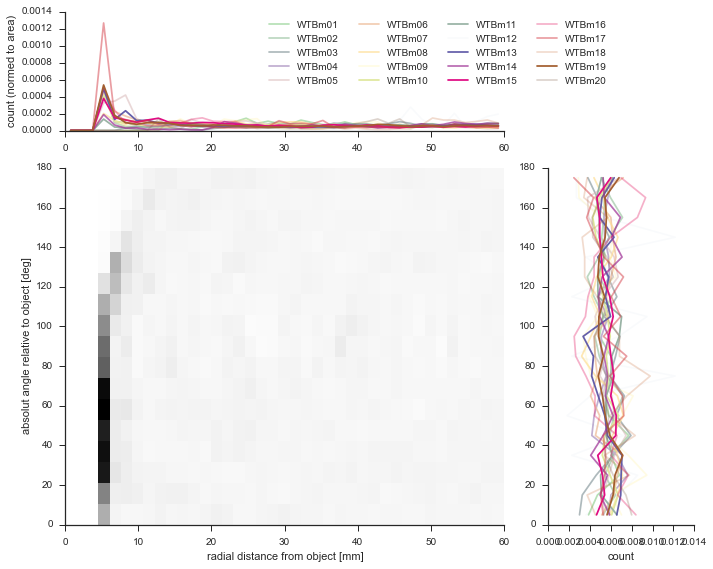

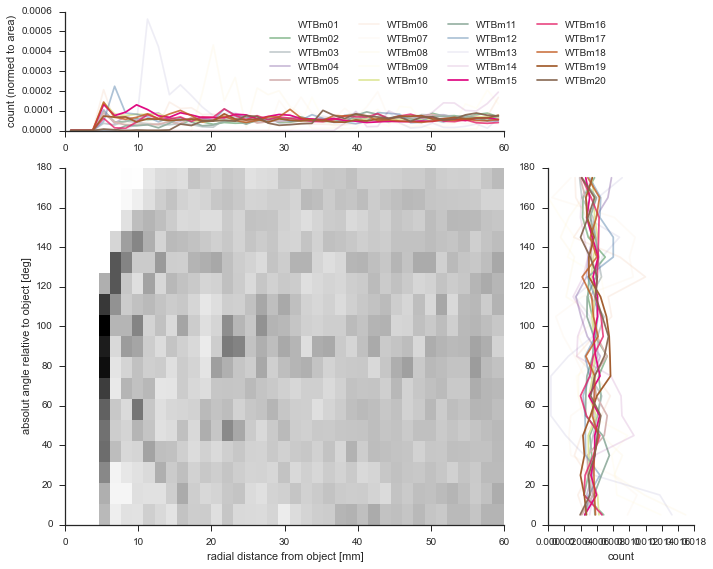

In [122]:
try:
    mkdir(analysisDir + sep + 'headingVsDistance' + sep)
except OSError:
    print('Analysis directory already exists.')

# plot parameter
distBins = 40
angleBins = 18
maxDist = arenaRad

# Note: Line plot alphas are proportional to amount of data the respective fly contrinuted
for ttind,trialtype in enumerate(['visible','invisible']):
    querystring = '(trialtype == "'+ trialtype +'") & (trial == '+ str(ttind+1+ttind*2) +') & (moving > 0) & (objectDistance < ' + str(maxDist) + ')'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    gammaall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
    flyIDallarray = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_fly:keyind_fly+1]).squeeze()

    headingDistFig = radDistAngleCombiPlot(distBins,angleBins,maxDist,flyIDs,flyIDallarray,xPosMAall,yPosMAall,gammaall)

    headingDistFig.savefig(analysisDir + 'headingVsDistance/'  + genotypeSex + '_' + trialtype
                           + '_headingVsDistanceHist_trial'+ str(ttind+1+ttind*2) +'_n'+ str(len(flyIDs)) +'.pdf',
                           format='pdf')

### Comparison of visible vs. invisible trials

Analysis directory already exists.


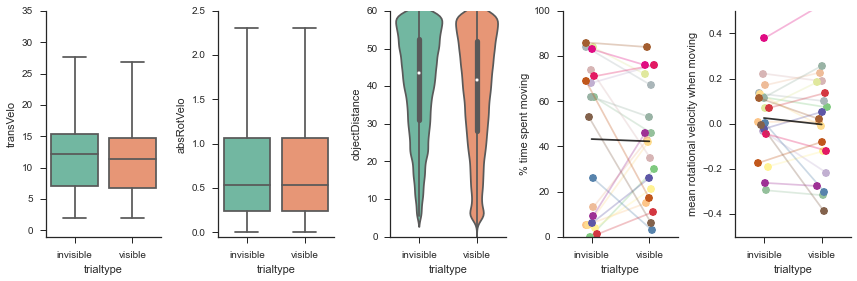

In [128]:
FOAllFliesMoving_df = FOAllFlies_df.query('(moving > 0)')
FOAllFliesMoving_df = FOAllFliesMoving_df[keylistLong]
FOAllFliesMoving_df.insert(0, 'absRotVelo', abs(FOAllFliesMoving_df['rotVelo']))

perTrialBP = plt.figure(figsize=(12,4))

perTrialBPvT = perTrialBP.add_subplot(151)
sns.boxplot(x='trialtype', y='transVelo', 
            data=FOAllFliesMoving_df, palette='Set2',sym='')
perTrialBPvT.set_ylim(-1,35)
myAxisTheme(perTrialBPvT)

perTrialBPvR = perTrialBP.add_subplot(152)
sns.boxplot(x='trialtype', y='absRotVelo',
            data=FOAllFliesMoving_df, palette='Set2',sym='')
perTrialBPvR.set_ylim(-0.05,2.5)
myAxisTheme(perTrialBPvR)

perTrialVPod = perTrialBP.add_subplot(153)
sns.violinplot(x='trialtype', y='objectDistance', data=FOAllFliesMoving_df,
               palette='Set2',sym='', bw=.1)
               #,inner='stick',  scale='count')
perTrialVPod.set_ylim(0,arenaRad)
myAxisTheme(perTrialVPod)

percentMoving = np.zeros((numFlies,2))
rotationBias = np.zeros((numFlies,2))
randJitter = np.zeros((numFlies,2))

perFlyMovingPlt = perTrialBP.add_subplot(154)
plt.xticks([1,2], ["invisible","visible"], rotation='horizontal')
perFlyRotBiasPlt = perTrialBP.add_subplot(155)
plt.xticks([1,2], ["invisible","visible"], rotation='horizontal')

keyind_mov = keylistLong.index('moving')
keyind_rot = keylistLong.index('rotVelo')

for fly in range(numFlies):
    for ttind,trialtype in enumerate(["invisible","visible"]):
        querystring = '(trialtype == "' + trialtype + '") & (flyID == "' + flyIDs[fly] +  '")'
        perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('bool')
        perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_rot:keyind_rot+1].squeeze().astype('float')        
        jitter = np.random.uniform(-0.1, 0.1)
        percentMoving[fly,ttind] = 100*sum(perFlyMoving)/max(1,len(perFlyMoving))
        rotationBias[fly,ttind] = np.mean(perFlyRot[perFlyMoving])
        randJitter[fly,ttind] = jitter
        perFlyMovingPlt.plot(ttind+1+jitter,percentMoving[fly,ttind],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        perFlyRotBiasPlt.plot(ttind+1+jitter,rotationBias[fly,ttind],'.',
                              markersize=15,color = flyCMap.to_rgba(fly))

    perFlyMovingPlt.plot(range(1,3)+randJitter[fly,:] ,percentMoving[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    perFlyRotBiasPlt.plot(range(1,3)+randJitter[fly,:] ,rotationBias[fly,:],'-',
                          markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
#plot average response
perFlyMovingPlt.plot(range(1,3),np.mean(percentMoving,axis=0),color='k',alpha=0.8)
perFlyRotBiasPlt.plot(range(1,3),np.mean(rotationBias,axis=0),color='k',alpha=0.8)

perFlyMovingPlt.set_ylim(0,100)
perFlyMovingPlt.set_xlim(0.5,2.5)
perFlyMovingPlt.set_xlabel('trialtype')
perFlyMovingPlt.set_ylabel('% time spent moving')
myAxisTheme(perFlyMovingPlt)

perFlyRotBiasPlt.set_ylim(-0.5,0.5)
perFlyRotBiasPlt.set_xlim(0.5,2.5)
perFlyRotBiasPlt.set_xlabel('trialtype')
perFlyRotBiasPlt.set_ylabel('mean rotational velocity when moving')
myAxisTheme(perFlyRotBiasPlt)

perTrialBP.tight_layout()

try:
    mkdir(analysisDir + sep + 'compareTrialtypes' + sep)
except OSError:
    print('Analysis directory already exists.')

perTrialBP.savefig(analysisDir + 'compareTrialtypes/'  + genotypeSex
                   + '_visibleVSinvisible_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

Analysis directory already exists.


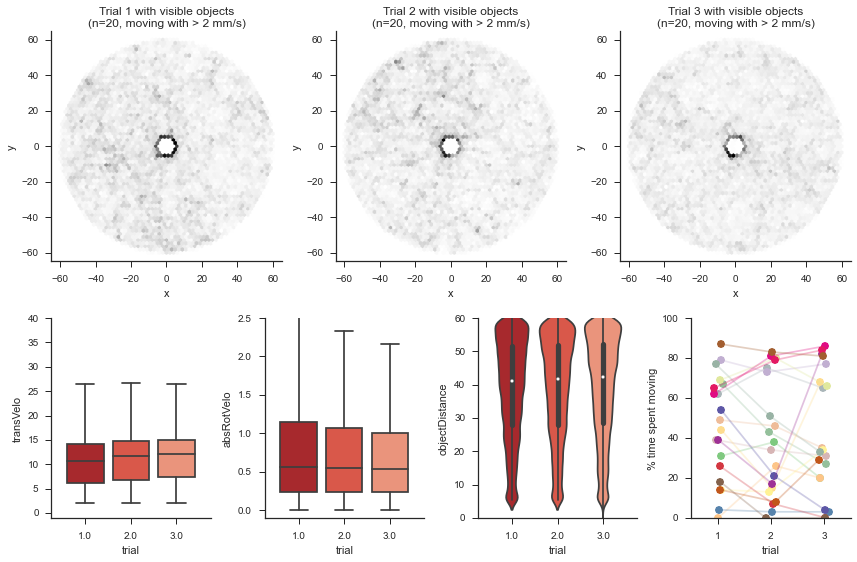

In [129]:
# make fly summary plot of residency:
arenaRad = 60
numBins = 60

trialComparisonFig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,12,height_ratios=[1,0.8])
numVItrials = 3
for trial in range(1,numVItrials+1):
    querystring = '(trial == ' + str(trial) + ')'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    movingall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1]).squeeze().astype('bool')

    # make plot
    sbplt = trialComparisonFig.add_subplot(gs[0,(trial-1)*4:trial*4]) #(1,numVItrials,trial)
    
    noNans = ~np.isnan(xPosMAall)
    titlestring = 'Trial '+str(trial)+' with visible objects\n(n='+str(nTrialsVI/numVItrials)+', moving with > '+str(vTransTH)+' mm/s)'

    hexplotfig_trial = plotResidencyInMiniarena(sbplt, xPosMAall[noNans][movingall[noNans]],
                                                yPosMAall[noNans][movingall[noNans]],numBins, arenaRad,
                                                'Greys',titlestring)

FOAllFliesVisible_df = FOAllFlies_df.query('(trialtype == "visible") & (trial < 4) & (moving > 0)')
FOAllFliesVisible_df = FOAllFliesVisible_df[keylistLong]

FOAllFliesVisible_df.insert(keylistLong.index('rotVelo'), 'absRotVelo', abs(FOAllFliesVisible_df['rotVelo']))

#perTrialBP = plt.figure(figsize=(13,4))
perTrialBPvT = trialComparisonFig.add_subplot(gs[1,0:3])
sns.boxplot(x='trial', y='transVelo', 
            data=FOAllFliesVisible_df, palette='Reds_r',sym='')
perTrialBPvT.set_ylim(-1,40)
perTrialBPvT.set_xlim(-0.75,2.75)
myAxisTheme(perTrialBPvT)

perTrialBPvR = trialComparisonFig.add_subplot(gs[1,3:6])
sns.boxplot(x='trial', y='absRotVelo',
            data=FOAllFliesVisible_df, palette='Reds_r',sym='')
perTrialBPvR.set_ylim(-0.1,2.5)
perTrialBPvR.set_xlim(-0.75,2.75)
myAxisTheme(perTrialBPvR)

perTrialVPod = trialComparisonFig.add_subplot(gs[1,6:9])
sns.violinplot(x='trial', y='objectDistance',data=FOAllFliesVisible_df,
               palette='Reds_r',sym='', bw=.1)
perTrialVPod.set_ylim(0,arenaRad)
perTrialVPod.set_xlim(-0.75,2.75)
myAxisTheme(perTrialVPod)

percentMoving = np.zeros((numFlies,3))
randJitter = np.zeros((numFlies,3))

perFlyMovingPlt = trialComparisonFig.add_subplot(gs[1,9:12])

for fly in range(numFlies):
    for trial in range(3):
        querystring = '(trialtype == "visible") & (trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '")'
        perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int')
        jitter = np.random.uniform(-0.1, 0.1)
        percentMoving[fly,trial] = 100*sum(perFlyMoving)/max(1,len(perFlyMoving))
        randJitter[fly,trial] = jitter
        perFlyMovingPlt.plot(trial+1+jitter,percentMoving[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))

    perFlyMovingPlt.plot(range(1,4)+randJitter[fly,:],percentMoving[fly,:],
                         '-',markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)

perFlyMovingPlt.set_xlabel('trial')
plt.xticks([1,2,3],[1,2,3], rotation='horizontal')
perFlyMovingPlt.set_ylabel('% time spent moving')
perFlyMovingPlt.set_ylim(0,100)
perFlyMovingPlt.set_xlim(0.5,3.5)
myAxisTheme(perFlyMovingPlt)

trialComparisonFig.tight_layout()

try:
    mkdir(analysisDir + sep + 'compareVisibleTrials' + sep)
except OSError:
    print('Analysis directory already exists.')

trialComparisonFig.savefig(analysisDir + 'compareVisibleTrials/'  + genotypeSex
                   + '_visibleTrials'+'_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

In [313]:
condition = "visible"
trial = 2
querystring = '(trialtype=="'+condition+'") & (trial=='+ str(trial) +') & (moving>0) & (objectDistance>5.5)'#& ((flyID== "WTBm10"))'
xPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
angleFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_ang:keyind_ang+1]).squeeze()
timeFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()
vTransFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
vRotFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1]).squeeze()

objDist = np.hypot(xPosFly,yPosFly)
theta = np.arctan2(yPosFly,xPosFly)
theta = theta + np.pi
thetaU = np.copy(theta)
thetaU[~np.isnan(theta)] = np.unwrap(theta[~np.isnan(theta)],discont=np.pi)

#first derivatives of the distance and angle
d_theta = np.hstack((0,np.diff(thetaU)))

#filter derivatives
sigma = 1
from scipy.ndimage.filters import gaussian_filter
d_theta_filt = gaussian_filter(d_theta, sigma, mode='reflect')

d_objDist = np.hstack((0, np.diff(objDist)))/d_theta_filt

d_objDist_filt = gaussian_filter(d_objDist, sigma, mode='reflect')

#second derivative
dd_objDist = np.hstack((0, np.diff(d_objDist_filt)))/d_theta_filt

polarCurv = (objDist**2 + 2*(d_objDist**2) - objDist*dd_objDist)/(np.sqrt(objDist**2 + d_objDist**2)**3)

# Compute sign of turn relative to object
turnSign = np.sign(polarCurv)
turnSign[d_theta>0] = np.sign(polarCurv[d_theta>0])
turnSign[d_theta<0] = -np.sign(polarCurv[d_theta<0])

# Compute curvature-based criterion for turns
q75, q25 = np.percentile(polarCurv[~np.isnan(polarCurv)], [75 ,25])
iqr = q75 - q25
print(iqr)
curveSelectTH = 10*iqr
curvSelect = abs(polarCurv)<curveSelectTH

# Generate filtered curvature for plots
polarCurvPlt = polarCurv[curvSelect]

# Compute magnitude of curves
curvMag = abs(polarCurv)

0.106705090948


In [314]:
# Get object related parameter
objDirectionFly, objDistFly, gammaFullFly, gammaFly, gammaVFly = relationToObject(timeFly,xPosFly,yPosFly,angleFly,[0,0])

<matplotlib.colorbar.Colorbar instance at 0x13ea363f8>

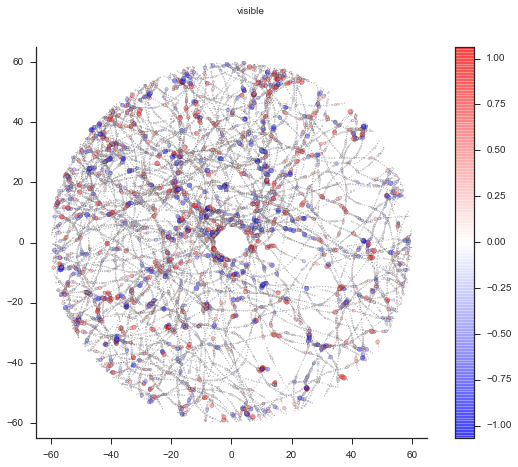

In [315]:
# Plot (filtered) curvature
fig = plt.figure(figsize=(10,7))
fig.suptitle(condition)
ax=fig.add_subplot(111)
sc = ax.scatter(xPosFly[curvSelect],yPosFly[curvSelect],s=curvMag[curvSelect]*100,c=abs(polarCurvPlt)*turnSign[curvSelect],alpha=0.5,marker='.',cmap='bwr')
ax.set_aspect('equal')
plt.xlim(-arenaRad-5,arenaRad+5)
plt.ylim(-arenaRad-5,arenaRad+5)
myAxisTheme(ax)
plt.colorbar(sc)

In [316]:
#curvBoxPlotall = curvatureVsHeading_DistanceBoxplot(abs(polarCurv[curvSelect])*turnSign[curvSelect], gammaFullFly[curvSelect], 
#                                                    objDistFly[curvSelect], 18, 4, arenaRad,
#                                                    'Modulation of trajectory curvature with relative heading angle')

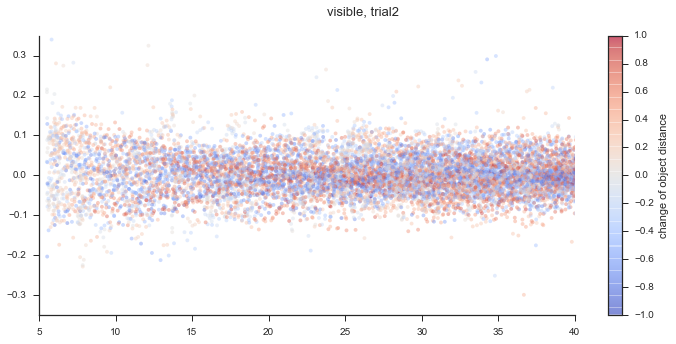

In [317]:
gammaFullFlyU = np.zeros(len(gammaFullFly))
gammaFullFlyU[~np.isnan(gammaFullFly)] = np.unwrap(gammaFullFly[~np.isnan(gammaFullFly)],discont=np.pi)

d_gamma = np.hstack((0,np.diff(gammaFullFlyU)))

d_objDist = np.hstack((0,np.diff(objDistFly)))
d_objDist[abs(d_objDist)>1] = 0.0

curvTH = 0.5
selectPts = curvMag<curvTH

fig = plt.figure(figsize=(12,5))
fig.suptitle(condition + ', trial' + str(trial), fontsize=13)
ax=fig.add_subplot(111)
sc = ax.scatter(objDistFly[selectPts],d_gamma[selectPts],s=15,c=d_objDist[selectPts],cmap='coolwarm',
                marker ='o',alpha=0.4,edgecolor='none')
ax.set_ylim(-0.35,0.35)
ax.set_xlim(5,40)
colbar = plt.colorbar(sc)
colbar.set_label('change of object distance')
myAxisTheme(ax)

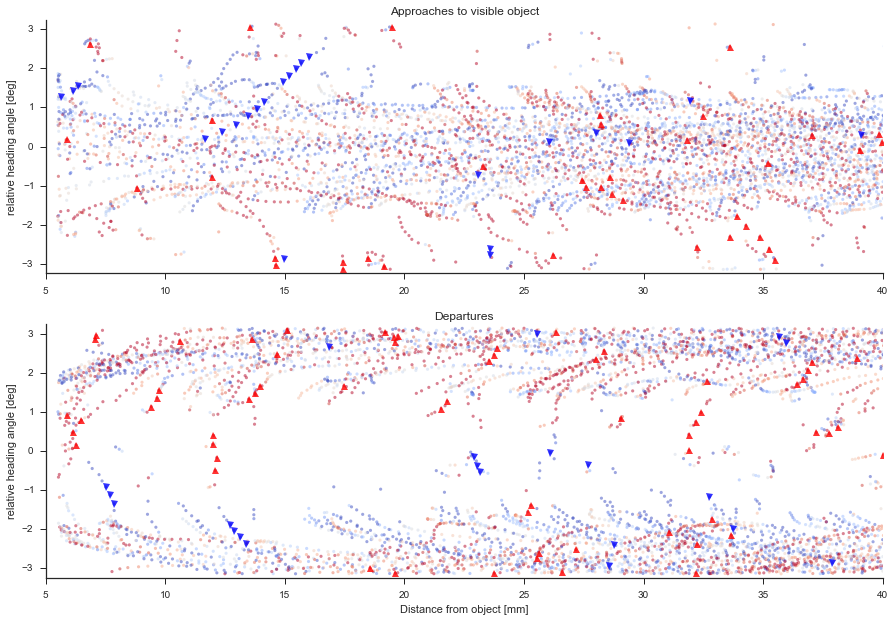

In [318]:
fig = plt.figure(figsize=(15,10))

turnTH = 3*np.std(abs(gaussian_filter(vRotFly, 1, mode='reflect')))

correctedPolarCurv = abs(polarCurv)*turnSign

ax=fig.add_subplot(211)
ax.set_title('Approaches to ' + condition + ' object')
selectPts = np.logical_and(objDistFly<60,d_objDist<0) # d_gamma>0.01)
selectPts_turnR = np.logical_and(np.logical_and(objDistFly<60,d_objDist<0),vRotFly<-turnTH*1.5)
selectPts_turnL = np.logical_and(np.logical_and(objDistFly<60,d_objDist<0),vRotFly>turnTH*1.5)

#ax.plot(objDistFly[objDistFly<30],theta[objDistFly<30],'.',color='grey',alpha=0.2)
#sc = ax.scatter(objDistFly[selectPts],theta[selectPts],s=20,c=d_objDist[selectPts],marker='o',
#           edgecolor='none',alpha=0.9,cmap='bwr',vmin=-1, vmax=1)
sc = ax.scatter(objDistFly[selectPts],gammaFullFly[selectPts],s=40,
                c=vRotFly[selectPts],marker='.',
                edgecolor='none',alpha=0.5,cmap='coolwarm',vmin=-.9, vmax=.9)
#ax.plot(objDistFly[selectPts],gammaFullFly[selectPts],'.',alpha=0.5,color='grey')
ax.plot(objDistFly[selectPts_turnR],gammaFullFly[selectPts_turnR],'v',color='b',alpha=0.8)
ax.plot(objDistFly[selectPts_turnL],gammaFullFly[selectPts_turnL],'^',color='r',alpha=0.8)

plt.xlim(5,40)
plt.ylim(-.1-np.pi,np.pi+.1)
ax.set_ylabel('relative heading angle [deg]')
#plt.colorbar(sc)
myAxisTheme(ax)

ax=fig.add_subplot(212)
ax.set_title('Departures')
selectPts = np.logical_and(objDistFly<60,d_objDist>0)# d_gamma>0.01)
selectPts_turnR = np.logical_and(np.logical_and(objDistFly<60,d_objDist>0),vRotFly<-turnTH*1.5)
selectPts_turnL = np.logical_and(np.logical_and(objDistFly<60,d_objDist>0),vRotFly>turnTH*1.5)

sc = ax.scatter(objDistFly[selectPts],gammaFullFly[selectPts],s=40,
                c=vRotFly[selectPts],marker='.',
                edgecolor='none',alpha=0.5,cmap='coolwarm',vmin=-.9, vmax=.9)
#ax.plot(objDistFly[selectPts],gammaFullFly[selectPts],'.',alpha=0.5,color='grey')
ax.plot(objDistFly[selectPts_turnR],gammaFullFly[selectPts_turnR],'v',color='b',alpha=0.8)
ax.plot(objDistFly[selectPts_turnL],gammaFullFly[selectPts_turnL],'^',color='r',alpha=0.8)

plt.xlim(5,40)
plt.ylim(-.1-np.pi,np.pi+.1)
ax.set_xlabel('Distance from object [mm]')
ax.set_ylabel('relative heading angle [deg]')
#plt.colorbar(sc)
myAxisTheme(ax)

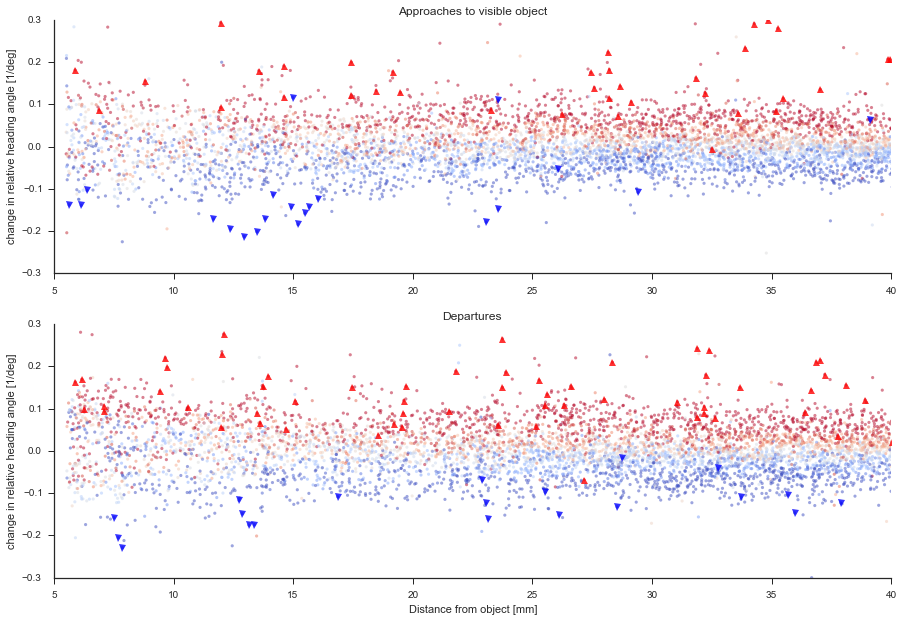

In [319]:
fig = plt.figure(figsize=(15,10))

turnTH = 3*np.std(abs(gaussian_filter(vRotFly, 1, mode='reflect')))

correctedPolarCurv = abs(polarCurv)*turnSign

ax=fig.add_subplot(211)
ax.set_title('Approaches to ' + condition + ' object')
selectPts = np.logical_and(objDistFly<60,d_objDist<0)
selectPts_turnR = np.logical_and(np.logical_and(objDistFly<60,d_objDist<0),vRotFly<-turnTH*1.5)
selectPts_turnL = np.logical_and(np.logical_and(objDistFly<60,d_objDist<0),vRotFly>turnTH*1.5)

sc = ax.scatter(objDistFly[selectPts],d_gamma[selectPts],s=40,
                c=vRotFly[selectPts],marker='.',
                edgecolor='none',alpha=0.5,cmap='coolwarm',vmin=-.9, vmax=.9)
ax.plot(objDistFly[selectPts_turnR],d_gamma[selectPts_turnR],'v',color='b',alpha=0.8)
ax.plot(objDistFly[selectPts_turnL],d_gamma[selectPts_turnL],'^',color='r',alpha=0.8)

ax.set_xlim(5,40)
ax.set_ylim(-0.3,0.3)
ax.set_ylabel('change in relative heading angle [1/deg]')
myAxisTheme(ax)

ax=fig.add_subplot(212)
ax.set_title('Departures')
selectPts = np.logical_and(objDistFly<60,d_objDist>0)
selectPts_turnR = np.logical_and(np.logical_and(objDistFly<60,d_objDist>0),vRotFly<-turnTH*1.5)
selectPts_turnL = np.logical_and(np.logical_and(objDistFly<60,d_objDist>0),vRotFly>turnTH*1.5)

sc = ax.scatter(objDistFly[selectPts],d_gamma[selectPts],s=40,
                c=vRotFly[selectPts],marker='.',
                edgecolor='none',alpha=0.5,cmap='coolwarm',vmin=-.9, vmax=.9)
ax.plot(objDistFly[selectPts_turnR],d_gamma[selectPts_turnR],'v',color='b',alpha=0.8)
ax.plot(objDistFly[selectPts_turnL],d_gamma[selectPts_turnL],'^',color='r',alpha=0.8)

ax.set_xlim(5,40)
ax.set_ylim(-0.3,0.3)
ax.set_xlabel('Distance from object [mm]')
ax.set_ylabel('change in relative heading angle [1/deg]')
#plt.colorbar(sc)
myAxisTheme(ax)

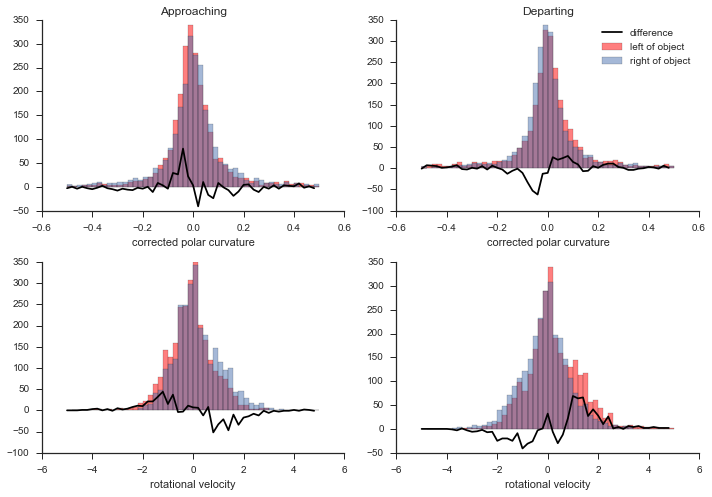

In [320]:
maxDist = 40
minDist = 5.5
distRange = np.logical_and(objDistFly>minDist,objDistFly<maxDist)
selectPts_ap_left = np.logical_and(np.logical_and(np.logical_and(distRange,d_objDist<0),gammaFullFly>0),vTransFly>vTransTH)
selectPts_ap_right = np.logical_and(np.logical_and(np.logical_and(distRange,d_objDist<0),gammaFullFly<0),vTransFly>vTransTH)
selectPts_de_left = np.logical_and(np.logical_and(np.logical_and(distRange,d_objDist>0),gammaFullFly>0),vTransFly>vTransTH)
selectPts_de_right = np.logical_and(np.logical_and(np.logical_and(distRange,d_objDist>0),gammaFullFly<0),vTransFly>vTransTH)

fig = plt.figure(figsize=(10,7))

#approach, curvature distribution
ax = fig.add_subplot(2,2,1)
n1 = plt.hist(correctedPolarCurv[selectPts_ap_left],50,alpha=0.5,range=(-.5,.5),color='red')
n2 = plt.hist(correctedPolarCurv[selectPts_ap_right],50,alpha=0.5,range=(-.5,.5))
ax.plot(n1[1][:-1],n1[0]-n2[0],'k')
ax.set_xlabel('corrected polar curvature')
ax.set_title('Approaching',fontsize=12)
myAxisTheme(ax)

#departure, curvature distribution
ax = fig.add_subplot(2,2,2)
n1 = plt.hist(correctedPolarCurv[selectPts_de_left],50,alpha=0.5,range=(-.5,.5),color='red')
n2 = plt.hist(correctedPolarCurv[selectPts_de_right],50,alpha=0.5,range=(-.5,.5))
ax.plot(n1[1][:-1],n1[0]-n2[0],'k')
ax.set_xlabel('corrected polar curvature')
ax.set_title('Departing',fontsize=12)
ax.legend(['difference','left of object', 'right of object'])
myAxisTheme(ax)

#approach, rotational velocity distribution
ax = fig.add_subplot(2,2,3)
n1 = plt.hist(vRotFly[selectPts_ap_left],50,alpha=0.5,range=(-5,5),color='red')
n2 = plt.hist(vRotFly[selectPts_ap_right],50,alpha=0.5,range=(-5,5));
ax.plot(n1[1][:-1],n1[0]-n2[0],'k')
ax.set_xlabel('rotational velocity')
myAxisTheme(ax)

#departure, rotational velocity distribution
ax = fig.add_subplot(2,2,4)
n1 = plt.hist(vRotFly[selectPts_de_left],50,alpha=0.5,range=(-5,5),color='red')
n2 = plt.hist(vRotFly[selectPts_de_right],50,alpha=0.5,range=(-5,5));
ax.plot(n1[1][:-1],n1[0]-n2[0],'k')
ax.set_xlabel('rotational velocity')
myAxisTheme(ax)

fig.tight_layout()

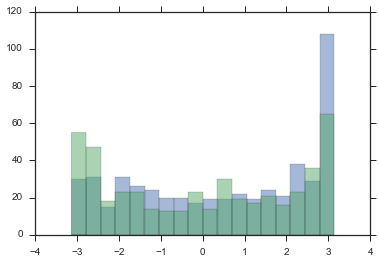

In [149]:
selectPts_turn1 = np.logical_and(np.logical_and(objDistFly<60,d_objDist>0),abs(polarCurv)*turnSign<-curveSelectTH)
selectPts_turn2 = np.logical_and(np.logical_and(objDistFly<60,d_objDist>0),abs(polarCurv)*turnSign>curveSelectTH)

plt.hist(gammaFullFly[selectPts_turn1],18,alpha=0.5);
plt.hist(gammaFullFly[selectPts_turn2],18,alpha=0.5);

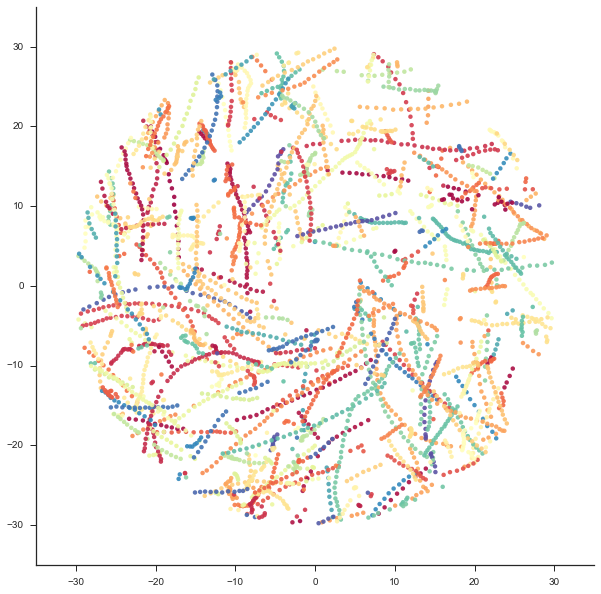

In [221]:
fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)

selectPts = np.logical_and(np.logical_and(objDistFly<30,d_objDist<0),d_gamma<-.01)

sc = ax.scatter(xPosFly[selectPts],yPosFly[selectPts],s=20,c=timeFly[selectPts],marker='o',
           edgecolor='none',alpha=0.9,cmap='Spectral')#,vmin=-0.1, vmax=0.1)
ax.set_aspect('equal')
plt.xlim(-35,35)
plt.ylim(-35,35)
myAxisTheme(ax)

### Per fly behavioural statistics

In [18]:
FOAllFliesVisible_df = FOAllFlies_df.query('(trialtype == "visible") & (trial < 4)')
FOAllFliesVisible_df = FOAllFliesVisible_df[keylistLong]

In [24]:
for fly in range(numFlies/5):
    querystring = '(flyID == "' + fileToAnalyse.split('_')[0][:-2] + str(fly+1).zfill(2) +  '")'
    perFlyMeans = FOAllFliesVisible_df.query(querystring).mean(0,skipna=True)
    print('\n fly ' + str(fly) + '\n')
    print(perFlyMeans)


 fly 0

moving                  0.634472
curvature          448415.913376
gamma                   1.622577
gammaFull              -0.332927
headingAngle            0.117333
objectDistance         35.913438
rotVelo                 0.054462
time                  300.004307
transVelo               4.594989
xPos                   21.198635
xPosInMiniarena        -0.930513
yPos                  -24.522972
yPosInMiniarena        -0.644062
dtype: float64

 fly 1

moving               0.546083
curvature                 NaN
gamma                1.585253
gammaFull                 NaN
headingAngle        -0.150239
objectDistance      40.072637
rotVelo              0.124221
time               300.004545
transVelo            3.898081
xPos               122.897724
xPosInMiniarena     -2.342669
yPos               -24.765901
yPosInMiniarena      7.919816
dtype: float64

 fly 2

moving               0.241611
curvature                 NaN
gamma                1.501085
gammaFull                 NaN
head